In [2]:
import time
import dare
import copy
import math
import random
from enum import Enum
import pandas as pd
import numpy as np
import itertools as it
# from ctgan import CTGAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.model_selection import train_test_split
import urllib.request as urllib
from fume import Dataset, FairnessMetric, FairnessDebuggingUsingMachineUnlearning

# Helper functions to generate synthetic dataset

In [3]:
class FairDebuggerEfficiencyTestWithSyntheticData:
    def __init__(self, n_instances_range, n_features_range, root_save_path, random_state = 18):
        self.inst_rng = n_instances_range
        self.feat_rng = n_features_range
        self.root_save_path = root_save_path
        self.random_state = random_state
        
    '''Inner dataloader class for synthetic datasets'''
    class SyntheticDatasetLoader(Dataset):
        def __init__(self, rootTrain, rootTest):
            Dataset.__init__(self, rootTrain = rootTrain, rootTest = rootTest)
            self.trainLattice, self.testLattice = self.__preprocessDatasetForCategorization(self.trainDataset),\
                                                  self.__preprocessDatasetForCategorization(self.testDataset)

        def getDataset(self):
            return self.dataset, self.trainDataset, self.testDataset

        def getDatasetWithNormalPreprocessing(self):
            return self.trainDataset, self.testDataset

        def getDatasetWithCategorizationPreprocessing(self, decodeAttributeValues = True):
            return self.trainLattice, self.testLattice

        def __preprocessDatasetForCategorization(self, dataset):
            df = copy.deepcopy(dataset)
            for col in df.columns:
                if col != "target":
                    df[col] = df[col].astype(str)
            return df
        
    '''Helper Functions'''
    def __establishCardinality(self, data, cardinality):
        normData = minmax_scale(data, 
                                feature_range = (0, 1), 
                                axis = 0)
        columnData = copy.deepcopy(np.transpose(normData))
        for idx, _ in enumerate(columnData):
            if idx == 0:
                columnData[idx][columnData[idx]>=0.5] = 1
                columnData[idx][columnData[idx]<0.5] = 0
                columnData[idx] = columnData[idx].astype(int)
            else:
                intervals = np.linspace(0, 1, cardinality + 1) 
                label = 2
                for i, _ in enumerate(intervals):
                    if i == len(intervals) - 1:
                        break
                    low = intervals[i]
                    high = intervals[i + 1]
                    for index, _ in enumerate(columnData[idx]):
                        if columnData[idx][index] >= low and columnData[idx][index] < high + 0.000001:
                            columnData[idx][index] = label
                    label += 1
            columnData[idx] = columnData[idx].astype(int)
        return np.transpose(columnData)

    def __getFeatureNames(self, n_features):
        colNames = []
        for i in range(0, n_features):
            colNames.append(f'Feature_{str(i + 1)}')
        return colNames

    def __initiateTrainTestSplit(self, dataset, test_size):
        trainX, testX, trainY, testY = train_test_split(dataset.drop('target', axis = 1) , 
                                                        dataset['target'], 
                                                        stratify = dataset['target'], 
                                                        test_size = test_size)
        trainX['target'] = trainY
        testX['target'] = testY
        train = trainX.reset_index(drop = True)
        test = testX.reset_index(drop = True)
        return train, test
    
    def __induceBias(self, dataset):
        df = copy.deepcopy(dataset)
        for i, _ in enumerate(df['Feature_1']):
            if df['Feature_1'][i] == 1 and df['target'][i] == 0:
                if random.uniform(0, 1) >= 0.5:
                    df.at[i, 'target'] = 1
        return df

    def __generateSynDataset(self, n_instances, n_features, cardinality = 2, test_size = 0.2):
        syn = make_classification(n_samples = n_instances,
                                  n_features = n_features,
                                  n_informative = n_features,
                                  n_redundant = 0,
                                  n_repeated = 0,
                                  n_classes = 2,
                                  random_state = self.random_state)
        data = self.__establishCardinality(data = syn[0],
                                           cardinality = cardinality)
        target = syn[1]
        df = pd.DataFrame(data, columns = self.__getFeatureNames(n_features))
        df['target'] = target.tolist()
        df = self.__induceBias(df)
        train, test = self.__initiateTrainTestSplit(df, test_size)
        return train, test
    
    def __recordTimeTakeByFairDebugger(self, train_save_path, test_save_path):
        start = time.time()
        dataloader = self.SyntheticDatasetLoader(rootTrain = train_save_path,
                                                 rootTest = test_save_path)
        fairnessDebug = FairnessDebuggingUsingMachineUnlearning(dataloader,
                                                                ["Feature_1", 1, 0],
                                                                "target",
                                                                FairnessMetric.PP)
        biasedSubsets = fairnessDebug.latticeSearchSubsets(3, (0.05, 0.15), "normal", True)
        end = time.time()
        time_taken = end - start
        return time_taken
        
    '''Main Functions to start the testing'''
    def testFairDebuggerForBinaryDatasets(self, dataset_test_size = 0.2):
        print(f'All experiment synthetic dataset will have {str(dataset_test_size * 100)}% as test size.')
        result = pd.DataFrame(columns = ["n_instances", "n_features", "Time Taken(s)"])
        for n_instances in range(self.inst_rng[0], self.inst_rng[1], self.inst_rng[2]):
            if n_instances == 0:
                continue
            for n_features in range(self.feat_rng[0], self.feat_rng[1], self.feat_rng[2]):
                if n_features == 0:
                    continue
                if n_instances == 200000 and n_features == 10:
                    continue
                print(f'Starting experiment for dataset having {str(n_instances)} instances and {str(n_features)} features.')
                train, test = self.__generateSynDataset(n_instances = n_instances,
                                                        n_features = n_features,
                                                        cardinality = 2,
                                                        test_size = dataset_test_size)
                train_save_path = f'{self.root_save_path}/train_{str(n_instances)}_inst_{str(n_features)}_feat.csv'
                test_save_path = f'{self.root_save_path}/test_{str(n_instances)}_inst_{str(n_features)}_feat.csv'
                train.to_csv(train_save_path, index = False)
                test.to_csv(test_save_path, index = False)
                time_taken = self. __recordTimeTakeByFairDebugger(train_save_path = train_save_path,
                                                                  test_save_path = test_save_path)
                print(f'Ended experiment after {str(time_taken)} seconds. \n')
                result.loc[len(result)] = [str(n_instances), str(n_features), str(time_taken)]
        return result
    
    def testFairDebuggerForCardinalityVariation(self, n_features, n_instances, cardinality_range, dataset_test_size = 0.2):
        print(f'All experiment synthetic dataset will have {str(dataset_test_size * 100)}% as test size.')
        result = pd.DataFrame(columns = ["cardinality", "Time Taken(s)"])
        print(f'All datasets are having {str(n_instances)} instances and {str(n_features)} features.')
        for cardinality in range(cardinality_range[0], cardinality_range[1], cardinality_range[2]):
            print(f'Starting experiment with cardinality = {str(cardinality)}')
            train, test = self.__generateSynDataset(n_instances = n_instances,
                                                        n_features = n_features,
                                                        cardinality = cardinality,
                                                        test_size = dataset_test_size)
            train_save_path = f'{self.root_save_path}/train_{str(n_instances)}_inst_{str(n_features)}_feat_{str(cardinality)}_cardinality.csv'
            test_save_path = f'{self.root_save_path}/test_{str(n_instances)}_inst_{str(n_features)}_feat_{str(cardinality)}_cardinality.csv'
            train.to_csv(train_save_path, index = False)
            test.to_csv(test_save_path, index = False)
            time_taken = self. __recordTimeTakeByFairDebugger(train_save_path = train_save_path,
                                                              test_save_path = test_save_path)
            print(f'Ended experiment after {str(time_taken)} seconds. \n')
            result.loc[len(result)] = [str(cardinality), str(time_taken)]
        return result

# Experiments

In [28]:
tester = FairDebuggerEfficiencyTestWithSyntheticData(n_instances_range = [0, 500001, 50000],
                                                     n_features_range = [0, 16, 5],
                                                     root_save_path = "Dataset/Synthetic_Datasets",
                                                     random_state = 18)

# Time taken vs # Instances and Time taken vs # Features (binary cardinality)

In [29]:
result = tester.testFairDebuggerForBinaryDatasets()
result

All experiment synthetic dataset will have 20.0% as test size.
Starting experiment for dataset having 50000 instances and 5 features.
level: 0


KeyboardInterrupt: 

# Time taken vs Feature Cardinality

In [7]:
result2 = tester.testFairDebuggerForCardinalityVariation(n_features = 10,
                                                         n_instances = 30000, 
                                                         cardinality_range = [2, 11, 1])

All experiment synthetic dataset will have 20.0% as test size.
All datasets are having 30000 instances and 10 features.
Starting experiment with cardinality = 2
level: 0


KeyboardInterrupt: 

In [15]:
result2

,cardinality,Time Taken(s)
0,2,131.44649481773376
1,3,116.22117853164673
2,4,77.3833589553833
3,5,111.20417380332947
4,6,87.72816944122314
5,7,106.73000502586365
6,8,89.0462875366211
7,9,136.9672257900238
8,10,147.91204047203064


In [8]:
result2 = pd.DataFrame({
    'Cardinality': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Time': [131.4464948, 116.2211785, 77.38335896, 111.2041738, 87.72816944, 106.730005, 89.04628754, 136.9672258, 147.9120405]
})

/var/folders/3k/v7fj195577gbhdvxbhyj6vjc0000gp/T/ipykernel_93253/74168857.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-s" (-> color='k'). The keyword argument will take precedence.
  plt.plot(result2['Cardinality'], result2['Time'], 'k-s', markerfacecolor='none', color='black', markersize=12)


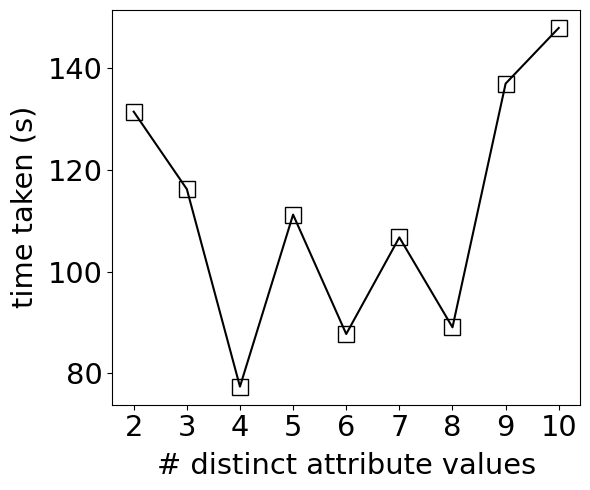

In [78]:
fsize = 25
lpad = 7
plt.figure(figsize=(6, 5)) # in inches!
plt.xticks(fontsize= fsize/1.2)
plt.yticks(fontsize= fsize/1.2)
plt.yticks(np.arange(60, 160, step=20))
# yticks()

plt.plot(result2['Cardinality'], result2['Time'], 'k-s', markerfacecolor='none', color='black', markersize=12)
# plt.legend(fontsize=fsize/1.2, loc='best')

plt.xlabel('# distinct attribute values',labelpad=lpad, fontsize=fsize/1.2)
plt.ylabel('time taken (s)',labelpad=lpad, fontsize=fsize/1.2)
plt.tight_layout()
plt.savefig('figures/Cardinality_efficiency_30000_inst_10_feat.pdf')

In [34]:
result = pd.DataFrame({
    '10features': [360, 4500, 7650, 24300, 36000],
    '20features': [495, 6750, 18000, 45000, 54000],
    '30features': [720, 8100, 31500, 54000, 72000]
})

/var/folders/3k/v7fj195577gbhdvxbhyj6vjc0000gp/T/ipykernel_93253/1777940133.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-s" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, result['10features'], 'k-s', color='blue', markersize=12, label = "10 features")
/var/folders/3k/v7fj195577gbhdvxbhyj6vjc0000gp/T/ipykernel_93253/1777940133.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-o" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, result['20features'], 'k-o', color='green', markersize=12, label = "20 features")
/var/folders/3k/v7fj195577gbhdvxbhyj6vjc0000gp/T/ipykernel_93253/1777940133.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-^" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, result['30features'], 'k-^', color='red', markersize=12, label = "30 feat

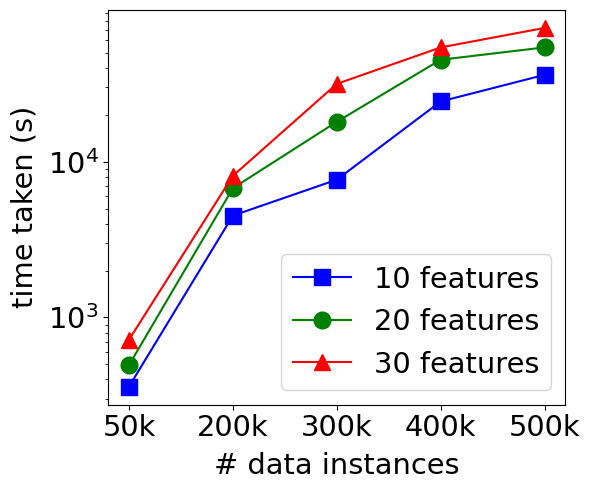

In [83]:
fsize = 25
lpad = 7
plt.figure(figsize=(6, 5)) # in inches!
plt.xticks(fontsize= fsize/1.2)
plt.yticks(fontsize= fsize/1.2)
# plt.yticks([20, 200, 500])

x = ["50k", "200k", "300k", "400k", "500k"]
plt.plot(x, result['10features'], 'k-s', color='blue', markersize=12, label = "10 features")
plt.plot(x, result['20features'], 'k-o', color='green', markersize=12, label = "20 features")
plt.plot(x, result['30features'], 'k-^', color='red', markersize=12, label = "30 features")
plt.legend(fontsize=fsize/1.2, loc='best')

plt.yscale("log")
plt.xlabel('# data instances',labelpad=lpad, fontsize=fsize/1.2)
plt.ylabel('time taken (s)',labelpad=lpad, fontsize=fsize/1.2)
plt.tight_layout()
plt.savefig('figures/DareRfEffiency_logscale_yaxis.pdf')